# Time-resolved energies and influence spectrum

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Energy vs time](#ene_time)
4. [Influence spectrum](#inf_spec)
   
### A. Learning objectives

* To be able to plot the computed excited states energies vs time
* To be able to compute and plot the influence spectrum

### B. Use cases


* [Energy vs time](#ene_time)
* [Influence spectrum](#inf_spec)


### C. Functions

- `libra_py`
  - `influence_spectrum`
    - [`recipe1`](#inf_spec)
  - `packages`
    - `cp2k`
      - `methods`
        - [`extract_energies_sparse`](#ene_time)
  - `units`
    - `au2ev`

## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Here, we import `numpy`, `matplotlib.pyplot`, `CP2K_methods`, and `influence_spectrum`.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from liblibra_core import *
import libra_py.packages.cp2k.methods as CP2K_methods
from libra_py import units, influence_spectrum

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

All the energy files are in this folder:

* `data/res-mb-sd-DFT`

## 3. Energy vs time <a name="ene_time"></a>
[Back to TOC](#toc)

Here, we will plot the energies of the many-body and single-particle excitation bases

<IPython.core.display.Javascript object>


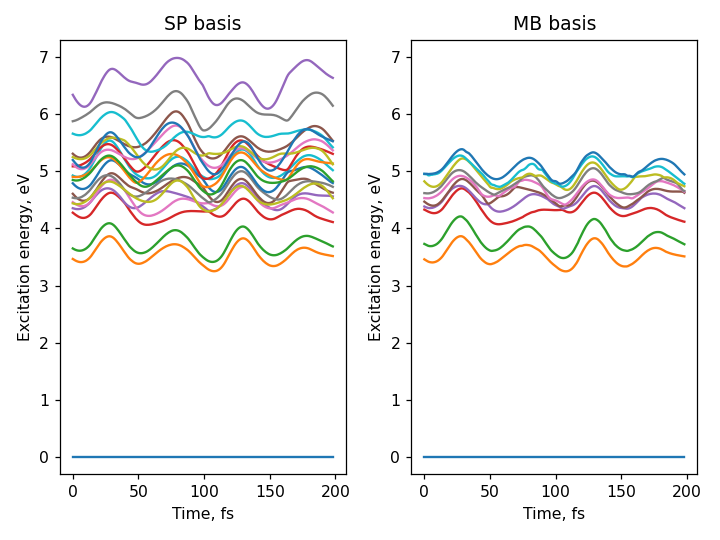

In [2]:
%matplotlib notebook
params = {"path_to_energy_files": "data/res-mb-sd-DFT", "dt": 1.0, 
          "prefix": "Hvib_sd_", "suffix": "_re", "istep": 1200, "fstep": 1399}

titles = ['SP basis', 'MB basis']
plt.figure()
for c, basis in enumerate(['sd','ci']):
    plt.subplot(1,2,c+1)
    params.update({"prefix": F"Hvib_{basis}_"})
    md_time, energies = CP2K_methods.extract_energies_sparse(params)
    energies = energies * units.au2ev
    for i in range(energies.shape[1]):
        plt.plot(md_time, energies[:,i]-energies[:,0])
    
    plt.title(titles[c])
    plt.ylabel('Excitation energy, eV')
    plt.xlabel('Time, fs')
    plt.ylim(-0.3, 7.3)
plt.tight_layout()

## 4. Influence spectrum <a name="inf_spec"></a>
[Back to TOC](#toc)


In order to compute the influence spectrum for the energy gap fluctuations between two states, `i` and `j`. The parameters that need to be passed to the function `influence_spectrum.recipe1` are as follows:

`data`: A list of `MATRIX(ndof, 1)` objects i.e. a sequence of real-valued ndof-dimensional vectors

`dt`: Time step in fs units
    
`wspan`: The window of frequencies for the Fourier transform with units cm$^{-1}$

`dw`: The grid points spacing in the frequency domain with units of cm$^{-1}$

`do_output`: Whether we print out the data the results into files

`acf_filename`: The name of the file where to print the ACF
    
`spectrum_filename`: The name of the file where to print the spectrum 

`do_center`: A flag controlling whether to center data (=`True`) or not (=`False`). Centering means we subtract the average value (over all the data points) from all the data points - this way, we convert values into their fluctuations 

`acf_type`: selector of the convention to to compute ACF:
```
   * 0 : the chemist convention,  (1/(N-h)) Sum_{t=1,N-h} (Y[t]*Y[t+h]) [ default ]
   * 1 : the statistician convention, (1/N) Sum_{t=1,N-h} (Y[t]*Y[t+h])
```

`data_type`: What is the format of the data?
```
        * 0 : list of MATRIX(ndof, 1) [ default ]
        * 1 : list of VECTOR
```

The `recipe1` function returns a tuple of (T, norm_acf, raw_acf, W, J, J2), where:

`T`: List with time axis in `fs` units

`norm_acf`: List with normalized ACF

`raw_acf`: List with un-normalized ACF

`W`: List with frequencies axis with units $cm^{-1}$

`J`: List with amplitudes of Fourier transform

`J2`: List with values of $(1/2\pi)|J|^2$

Select two states of interest to compute the influence spectrum for their energy gap fluctuations. Here we comute that for the ground state, `i=0`, and the first excited state, `j=1` and then plot the spectrum.

<IPython.core.display.Javascript object>


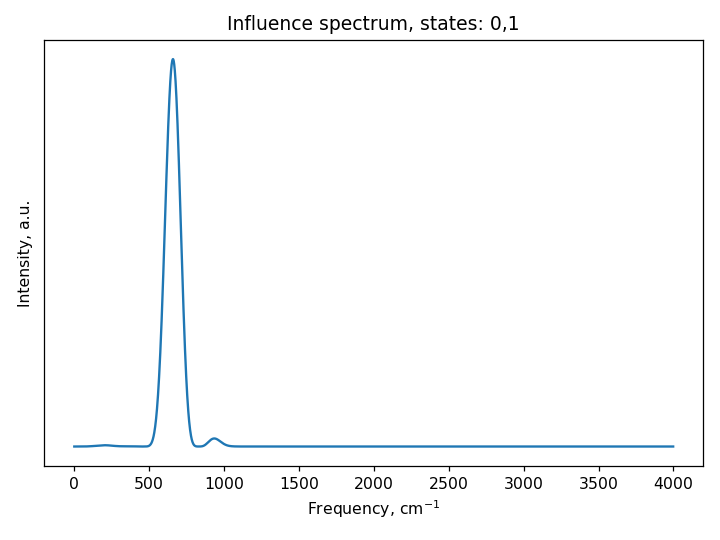

In [6]:
%matplotlib notebook
# For computing influence spectra
params_inf_cpec = {"dt": 1.0, "wspan": 4000.0, "dw": 1.0, "do_output": False,
          "do_center": True, "acf_type": 1, "data_type": 0}
# ==========
# Selecting the two states we want to compute the influence spectra for
i = 0; j = 1
# ========== Computing the autocorrelation function and the influence spectra
data_ij = []
for step in range(energies.shape[0]):
    x = MATRIX(1,1)
    if i<j:
        gap = energies[step,j]-energies[step,i]
    else:
        gap = energies[step,i]-energies[step,j]
    x.set(0,0, gap)
    data_ij.append(x)
Tij, ACFij, uACFij, Wij, Jij, J2ij = influence_spectrum.recipe1(data_ij, params_inf_cpec)

plt.plot(Wij, J2ij)
plt.xlabel('Frequency, cm$^{-1}$')
plt.ylabel('Intensity, a.u.')
plt.yticks([])
plt.title(F'Influence spectrum, states: {i},{j}')
plt.tight_layout()